# Task Overview

In this task, your goal is to verify the impact of data noise level in neural network training.
You should use MLP architecture trained on MNIST dataset (like in previous lab exercises).


We will experiment with two setups:
1. Pick X. Take X% of training examples and reassign their labels to random ones. Note that we don't change anything in the test set.
2. Pick X. During each training step, for each sample, change values of X% randomly selected pixels to random values. Note that we don't change anything in the test set.

For both setups, check the impact of various levels of noise (various values of X%) on model performance. Show plots comparing crossentropy (log-loss) and accuracy with varying X%, and also comparing two setups with each other.
Prepare short report briefly explaining the results and observed trends. Consider questions like "why accuracy/loss increases/decreases so quickly/slowly", "why Z is higher in setup 1/2" and any potentially surprising things you see on charts.

### Potential questions, clarifications
* Q: Can I still use sigmoid/MSE loss?
  * You should train your network with softmax and crossentropy loss (log-loss), especially since you should report crossentropy loss.
* Q: When I pick X% of pixels/examples, does it have to be exactly X% or can it be X% in expectation?
  * A: It's fine either way.
* Q: When I randomize pixels, should I randomize them again each time a particular example is drawn (each training step/epoch) or only once before training?
  * A: Each training step/epoch.
* Q: When I randomize labels, should I randomize them again each time a particular example is drawn (each training step/epoch) or only once before training?
  * A: Only once before training.
* Q: What is the expected length of report/explanation?
  * A: There is no minimum/maximum, but between 5 (concise) and 20 sentences should be good. Don't forget about plots.
* Q: When I replace labels/pixels with random values, what random distribution should I use?
  * A: A distribution reasonably similar to the data. However, you don't need to match dataset's distribution exactly - approximation will be totally fine, especially if it's faster or easier to get.
* Q: Can I use something different than Colab/Jupyter Notebook? E.g. just Python files.
  * A: Yes, although notebook is encouraged; please include in you solution code and pdf.

# Model definition and training.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # After flattening an image of size 28x28 we have 784 inputs
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output


def train0(model, device, train_loader, optimizer, epoch, log_interval, debug=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if debug == True and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, debug=True):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    if debug == True:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct / len(test_loader.dataset)

In [3]:
batch_size = 256
test_batch_size = 1000
epochs = 5
lr = 1e-2
use_cuda = False
seed = 1
log_interval = 10

In [4]:
use_cuda = not use_cuda and torch.cuda.is_available()

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [5]:
def get_loaders0():
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                        transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                        transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    return train_loader, test_loader

In [6]:
def train_and_test0(debug=True):
    train_loader, test_loader = get_loaders0()
    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    accuracies = []
    for epoch in range(1, epochs + 1):
        train0(model, device, train_loader, optimizer, epoch, log_interval, debug)
        loss, accuracy = test(model, device, test_loader, debug)

        losses.append(loss)
        accuracies.append(accuracy)

    return losses, accuracies

In [7]:
_,_ = train_and_test0()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313259
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.732760
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.582762
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.481087
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.334523
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.346265
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.229349
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.191099
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.224889
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.244065
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.236049
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.241033
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.194208
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.302403
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.203934
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.192445
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.173173
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.140804
Train Epoch: 1 [46080/60000 (77%)

# Training models in setup 1: with randomized labels.

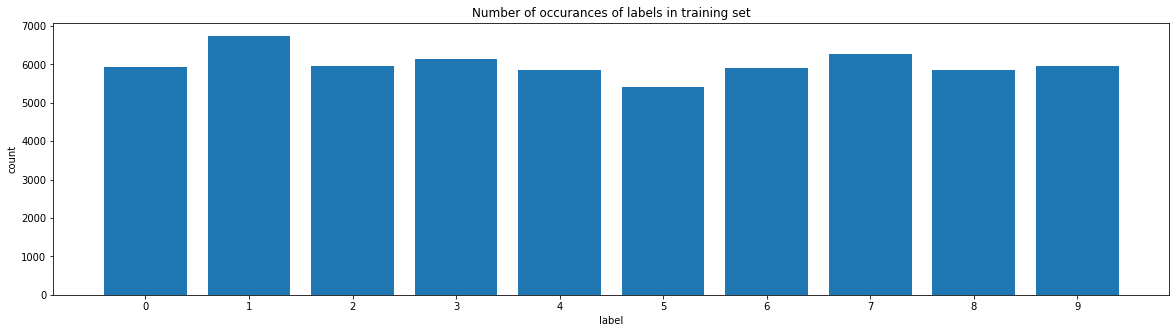

In [8]:
dataset1 = datasets.MNIST('../data', train=True, download=True)
values, counts = np.unique(dataset1.targets, return_counts=True)

fig, ax = plt.subplots(figsize=(20,5))
ax.bar(x = values, height=counts)

ax.set_title('Number of occurances of labels in training set')
ax.set_xlabel('label')
ax.set_ylabel('count')
ax.set_xticks(range(10))
ax.set_xticklabels(values, minor=False)

plt.show()

In [9]:
def get_loaders1(X):
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                        transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                        transform=transform)
    
    targets1 = dataset1.targets
    noise_size = int(X * len(targets1))
    rng = np.random.default_rng()
    idx = rng.choice(len(targets1), size = noise_size, replace=False)
    targets1.numpy()[idx] = rng.choice(10, size = noise_size)
    
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    return train_loader, test_loader

In [10]:
def train_and_test1(X, debug=True):
    train_loader, test_loader = get_loaders1(X)
    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    accuracies = []
    for epoch in range(1, epochs + 1):
        train0(model, device, train_loader, optimizer, epoch, log_interval, debug)
        loss, accuracy = test(model, device, test_loader, debug)

        losses.append(loss)
        accuracies.append(accuracy)

    return losses, accuracies

In [11]:
_,_ = train_and_test1(0.8)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304250
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.276753
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.259252
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.255265
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.265217
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.240115
Train Epoch: 1 [15360/60000 (26%)]	Loss: 2.276195
Train Epoch: 1 [17920/60000 (30%)]	Loss: 2.237165
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.262434
Train Epoch: 1 [23040/60000 (38%)]	Loss: 2.246944
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.243537
Train Epoch: 1 [28160/60000 (47%)]	Loss: 2.268574
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.280679
Train Epoch: 1 [33280/60000 (55%)]	Loss: 2.229026
Train Epoch: 1 [35840/60000 (60%)]	Loss: 2.226317
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.236477
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.246605
Train Epoch: 1 [43520/60000 (72%)]	Loss: 2.262032
Train Epoch: 1 [46080/60000 (77%)]	Loss: 2.182027
Train Epoch: 1 [48640/60000 (81%)]	Loss: 2.260547
Train Epoc

# Training models in setup 2: with randomized pixels.

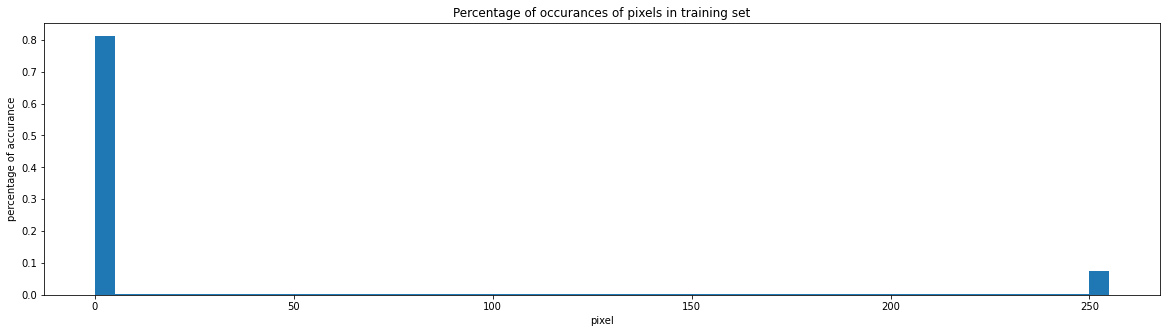

In [27]:
dataset1 = datasets.MNIST('../data', train=True, download=True)
values, counts = np.unique(dataset1.data, return_counts=True)

npixels = np.prod(dataset1.data.shape)
fig, ax = plt.subplots(figsize=(20,5))
ax.hist(x = values, weights=counts / npixels, bins = 50)

ax.set_title('Percentage of occurances of pixels in training set')
ax.set_xlabel('pixel')
ax.set_ylabel('percentage of accurance')

plt.show()

In [13]:
cooridations = list(itertools.product(range(28), range(28)))
def train2(model, device, train_loader, optimizer, epoch, log_interval, X, debug=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
            
        rng = np.random.default_rng()
        batch_size = data.shape[0]
        noise_size = int(X * data.shape[2] * data.shape[3])
        idx = rng.choice(cooridations, size = noise_size, replace=False)

        idx1 = idx[:, 0]
        idx2 = idx[:, 1]
            
        data.numpy()[:, 0, idx1, idx2] = rng.choice(np.array([-0.4242, 2.8215]), size = batch_size*noise_size, p=[0.8, 0.2]).reshape(batch_size, -1)

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if debug == True and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [14]:
def train_and_test2(X, debug=True):
    train_loader, test_loader = get_loaders0()
    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    accuracies = []
    for epoch in range(1, epochs + 1):
        train2(model, device, train_loader, optimizer, epoch, log_interval, X, debug)
        loss, accuracy = test(model, device, test_loader, debug)

        losses.append(loss)
        accuracies.append(accuracy)

    return losses, accuracies

In [15]:
_,_ = train_and_test2(0.8)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301327
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.134293
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.976478
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.795845
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.672444
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.802034
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.738611
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.703854
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.640632
Train Epoch: 1 [23040/60000 (38%)]	Loss: 1.681580
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.585288
Train Epoch: 1 [28160/60000 (47%)]	Loss: 1.736216
Train Epoch: 1 [30720/60000 (51%)]	Loss: 1.650995
Train Epoch: 1 [33280/60000 (55%)]	Loss: 1.583838
Train Epoch: 1 [35840/60000 (60%)]	Loss: 1.784999
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.729549
Train Epoch: 1 [40960/60000 (68%)]	Loss: 1.755109
Train Epoch: 1 [43520/60000 (72%)]	Loss: 1.786769
Train Epoch: 1 [46080/60000 (77%)]	Loss: 2.008936
Train Epoch: 1 [48640/60000 (81%)]	Loss: 1.549094
Train Epoc

# Plots and report.

In [16]:
def get_results(Xs):
    results = {}
    results_setup1 = {}
    results_setup2 = {}

    for X in Xs:
        print(f'Training setup 1 for X = {X*100}%')
        losses, accuracies = train_and_test1(X, debug=False)
        results_setup1[X] = (losses, accuracies)

    for X in Xs:
        print(f'Training setup 2 for X = {X*100}%')
        losses, accuracies = train_and_test2(X, debug=False)
        results_setup2[X] = (losses, accuracies)

    results[1] = results_setup1
    results[2] = results_setup2

    return results

results = get_results([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

Training setup 1 for X = 0.0%
Training setup 1 for X = 10.0%
Training setup 1 for X = 20.0%
Training setup 1 for X = 30.0%
Training setup 1 for X = 40.0%
Training setup 1 for X = 50.0%
Training setup 1 for X = 60.0%
Training setup 1 for X = 70.0%
Training setup 1 for X = 80.0%
Training setup 1 for X = 90.0%
Training setup 1 for X = 100.0%
Training setup 2 for X = 0.0%
Training setup 2 for X = 10.0%
Training setup 2 for X = 20.0%
Training setup 2 for X = 30.0%
Training setup 2 for X = 40.0%
Training setup 2 for X = 50.0%
Training setup 2 for X = 60.0%
Training setup 2 for X = 70.0%
Training setup 2 for X = 80.0%
Training setup 2 for X = 90.0%
Training setup 2 for X = 100.0%


In [17]:
import plotly.express as px
import plotly.graph_objects as go

def plot_accuracies_and_losses(X, setup):
    losses, accuracies = results[setup][X]

    fig = go.Figure(data=[
        go.Bar(name='loss', x=list(range(1, 6)), y=losses),
        go.Bar(name='accuracy', x=list(range(1, 6)), y=accuracies)
    ])
    
    fig.update_layout(
        barmode='group',
        title_text=f'Accuracy and loss after each epoch for X = {X*100}% for setup {setup}',
        title_x = 0.5,
        xaxis_title="Epoch",
        yaxis_title="Value",)
    fig.show()

In [18]:
def plot_multiple_accuracies_and_losses(Xs, setup):
    for X in Xs:
        plot_accuracies_and_losses(X, setup)

In [19]:
plot_multiple_accuracies_and_losses([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 1)

In [20]:
plot_multiple_accuracies_and_losses([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 2)

In [21]:
def plot_comparison_for_different_X(Xs, setup):
    losses_of_5th_epoch = []
    accuracies_of_5th_epoch = []
    for key, (losses, accuracies) in results[setup].items():
        if key in Xs:
            losses_of_5th_epoch.append(losses[-1])
            accuracies_of_5th_epoch.append(accuracies[-1])

    x = [f'({X*100}%)' for X in Xs]
    fig = go.Figure(data=[
        go.Bar(name='loss', x=x, y=losses_of_5th_epoch),
        go.Bar(name='accuracy', x=x, y=accuracies_of_5th_epoch)
    ])
    
    fig.update_layout(
        barmode='group',
        title_text=f'Accuracy and loss after 5th epoch for setup {setup}',
        title_x = 0.5,
        xaxis_title="X",
        yaxis_title="Value",)
    fig.show()

In [22]:
plot_comparison_for_different_X([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 1)

In [23]:
plot_comparison_for_different_X([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 2)

In [24]:
def plot_comparison_for_different_setups(Xs):
    losses_of_5th_epoch = [[] for _ in range(3)]
    accuracies_of_5th_epoch = [[] for _ in range(3)]

    for i in range(1, 3):
        for key, (losses, accuracies) in results[i].items():
            if key in Xs:
                losses_of_5th_epoch[i].append(losses[-1])
                accuracies_of_5th_epoch[i].append(accuracies[-1])

    x = [f'({X*100}%)' for X in Xs]
    fig = go.Figure(data=[
        go.Bar(name='loss for setup 1', x=x, y=losses_of_5th_epoch[1]),
        go.Bar(name='loss for setup 2', x=x, y=losses_of_5th_epoch[2])
    ])
    
    fig.update_layout(
        barmode='group',
        title_text=f'Accuracy after 5th epoch for two setups',
        title_x = 0.5,
        xaxis_title="X",
        yaxis_title="Value",)
    fig.show()

    x = [f'({X*100}%)' for X in Xs]
    fig = go.Figure(data=[
        go.Bar(name='accuracy for setup 1', x=x, y=accuracies_of_5th_epoch[1]),
        go.Bar(name='accuracy for setup 2', x=x, y=accuracies_of_5th_epoch[2])
    ])
    
    fig.update_layout(
        barmode='group',
        title_text=f'Loss after 5th epoch for two setups',
        title_x = 0.5,
        xaxis_title="X",
        yaxis_title="Value",)
    fig.show()

In [25]:
plot_comparison_for_different_setups([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# Report

From the above plots, we can observe a decrease in accuracy and an increase in loss when X increases. Noise in the labels leads to a slower decrease in accuracy than noise in the images, which is especially visible for bigger X. Between 0% and 80% of noise in the labels, the accuracy only drops by about 10 percentage points. Between 80% and 90%, a decrease is much sharper. With the noise in the pictures, the decrease is more noticeable. Already between 0% and 50%, the accuracy drops by about 10 percentage points.

It is worth noting that the loss initially grows faster for the noise in the labels and only for X> 50% does this trend reverses.

It seems to me that the slow decrease of accuracy for the noise in the labels is because the distribution of the labels in the training set is more or less uniform, so for a given digit in the pictures, we get more labels with that digit than with any other digit. A faster drop in accuracy for noise in images may be due to a preponderance of bright pixels, which leads to the loss of information from dark pixels when X increase.